# Neural Network Evaluation

## Data

First, we import useful packages.

In [1]:
#basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, recall_score
from sklearn.decomposition import PCA

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 17

2022-12-21 11:50:27.690711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Columns to be considered in the dataset
columns = ["LB", "AC", "FM", "UC", "DL", "DP", 
           "ASTV", "MSTV", "ALTV", "MLTV", "Width", "Min", 
           "Max", "Nmax", "Nzeros", "Mode", "Mean", "Median", "Variance", "Tendency"]

path = "../data/"

### Clean 

We load the preprocessed dataset.

In [3]:
filename = "prep_data.csv"

df = pd.read_csv(path+filename)
df = df.reindex(np.random.permutation(df.index))

#Prepare X and y
X = df[columns]
y = df["NSP"]

#One-hot enconding of target values 
y_cat = utils.to_categorical(y-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, train_size=0.8,random_state=45)

### Real

We load the raw dataset.

In [4]:
filename = "CTG.xls"

df_raw = pd.read_excel(path+filename, sheet_name = "Data",header=1)
df_raw = df_raw.reindex(np.random.permutation(df_raw.index))

#Prepare X and y
X_raw = df_raw[columns]
y_raw = df_raw["NSP"]

#One-hot enconding of target values 
y_cat_raw = utils.to_categorical(y_raw-1)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_cat_raw, train_size=0.8,random_state=45)

## Evaluation 

The final evaluation of the developed neural network is carried out by applying the optimised model to the raw dataset. In order to obtain meaningful feedback on the quality of the neural network, we will perform the final analysis by comparing our optimised model with some of the models developed during the analysis. In particular, we analyse:

- Complete strategy without dropout
- Complete strategy with dropout
- PCA strategy

### Complete strategy + No dropout

We test the model trained without PCA and dropout with the real dataset to see how well it performs. 

2022-12-21 11:50:35.277375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 32,703
Trainable params: 32,703
Non-trainable params: 0
_________________________________________________________________
67/67 [==============================] - 0s 911us/st

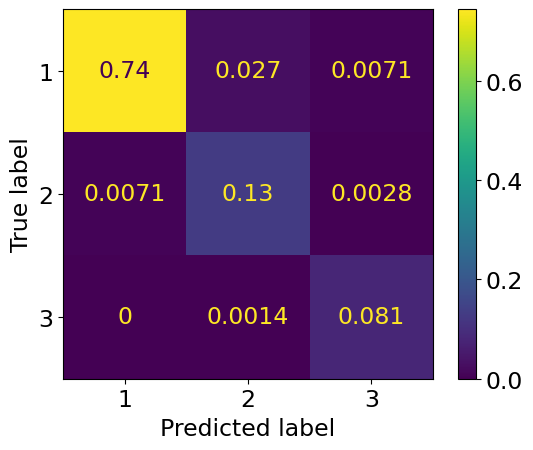

In [5]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

model_trace = model.fit(X_train,y_train, verbose=0,epochs=150, validation_data=(X_test, y_test))
y_pred = model.predict(X_raw)

y_pred = np.argmax(y_pred,axis=1)
y_compare = np.argmax(y_cat_raw,axis=1)

print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))

cm = confusion_matrix(y_compare, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
disp.plot();
#plt.savefig("../results/complete_strat_nopca")

### Complete strategy  + 0.1 dropout

We test the optimised model, i.e., trained without PCA and with 0.1 dropout, with the raw dataset to see how well it performs. 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               2100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 100)              

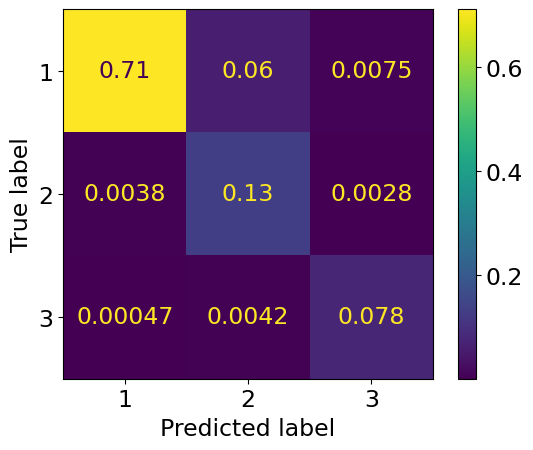

In [6]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given


model_trace = model.fit(X_train,y_train, verbose=0,epochs=150, validation_data=(X_test, y_test))
y_pred = model.predict(X_raw)

y_pred = np.argmax(y_pred,axis=1)
y_compare = np.argmax(y_cat_raw,axis=1)

print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))

cm = confusion_matrix(y_compare, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
disp.plot();

#plt.savefig("../results/complete_strat_pca")

### PCA strategy

Apply PCA as done in notebook *4_NN_PCA*:

In [7]:
pca = PCA(3) 

# Apply PCA to pre-processed data
X3 = pca.fit_transform(X)

# Apply PCA to real data
X3_raw = pca.fit_transform(X_raw)

# Split in train and test dataset
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y_cat, random_state = 45, train_size = 0.8)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               400       
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 3)                 303       
                                                                 
Total params: 31,003
Trainable params: 31,003
Non-trainable params: 0
_________________________________________________________________
67/67 [==============================] - 0s 914us/

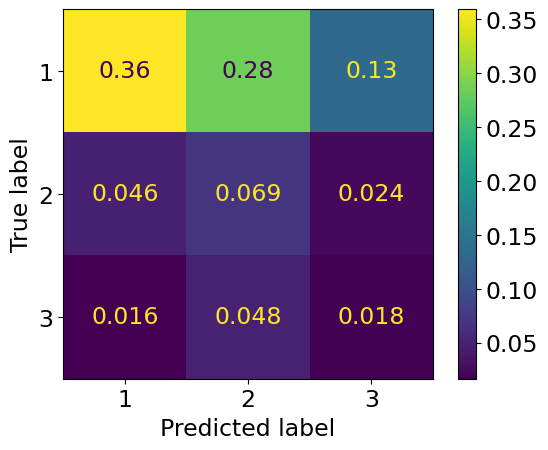

In [8]:
model = Sequential()
model.add(Dense(100, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=150,validation_data=(X3_test, y3_test))
y_pred = model.predict(X3_raw)

y_pred = np.argmax(y_pred,axis=1)
y_compare = np.argmax(y_cat_raw,axis=1)

print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))

cm = confusion_matrix(y_compare, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
disp.plot();

#plt.savefig("../results/pca_strat")